In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


# 2. Data Preparation

2.1 Load data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

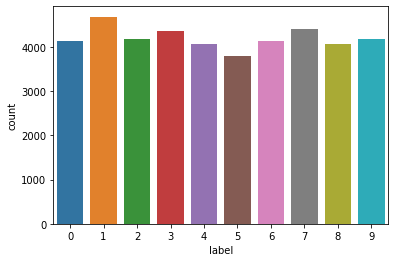

In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1)
del train
g = sns.countplot(Y_train)
Y_train.value_counts()

2.2 Check for null and missing values

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
Y_train.isnull().any()

False

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

2.3 Normalization

why we need to do normalization????

In [7]:
X_train = X_train / 255.0
test = test / 255.0

2.4 Reshape

In [8]:
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [21]:
test = test.values.reshape(-1,28,28,1)

2.5 Label encoding

In [9]:
Y_train = to_categorical(Y_train, num_classes = 10)

2.6 split into train and validation set

In [10]:
#unbalanced dataset can use stratify = True
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 10)

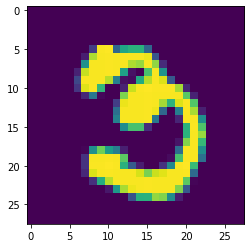

In [11]:
g = plt.imshow(X_train[0][:, :, 0])

# 3. CNN Training

CNN Define the model

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [17]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 78s - loss: 0.4224 - accuracy: 0.8641 - val_loss: 0.0682 - val_accuracy: 0.9779
Epoch 2/30


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 79s - loss: 0.1293 - accuracy: 0.9615 - val_loss: 0.0830 - val_accuracy: 0.9764
Epoch 3/30
 - 84s - loss: 0.0985 - accuracy: 0.9699 - val_loss: 0.0384 - val_accuracy: 0.9867
Epoch 4/30
 - 85s - loss: 0.0827 - accuracy: 0.9760 - val_loss: 0.0341 - val_accuracy: 0.9890
Epoch 5/30
 - 86s - loss: 0.0741 - accuracy: 0.9784 - val_loss: 0.0311 - val_accuracy: 0.9890
Epoch 6/30
 - 86s - loss: 0.0703 - accuracy: 0.9804 - val_loss: 0.0204 - val_accuracy: 0.9926
Epoch 7/30
 - 89s - loss: 0.0680 - accuracy: 0.9798 - val_loss: 0.0215 - val_accuracy: 0.9938
Epoch 8/30
 - 89s - loss: 0.0654 - accuracy: 0.9822 - val_loss: 0.0236 - val_accuracy: 0.9924
Epoch 9/30
 - 92s - loss: 0.0620 - accuracy: 0.9817 - val_loss: 0.0196 - val_accuracy: 0.9926
Epoch 10/30
 - 93s - loss: 0.0621 - accuracy: 0.9827 - val_loss: 0.0367 - val_accuracy: 0.9898
Epoch 11/30
 - 100s - loss: 0.0604 - accuracy: 0.9829 - val_loss: 0.0375 - val_accuracy: 0.9867
Epoch 12/30
 - 96s - loss: 0.0630 - accuracy: 0.9825 - val_loss: 0.0

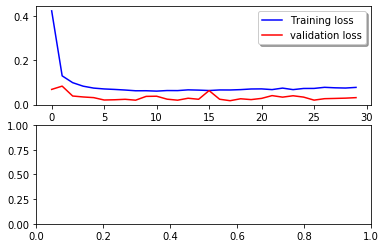

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
# ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
# legend = ax[1].legend(loc='best', shadow=True)

In [22]:
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
my_submission = pd.DataFrame({'ImageId': range(1,28001), 'Label': results})
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

my_submission.to_csv("submission.csv",index=False)